## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Смирнов Михаил Андреевич

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch import nn
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train

%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [21]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [22]:
images_train, labels_train = next(iter(train_loader))

In [23]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

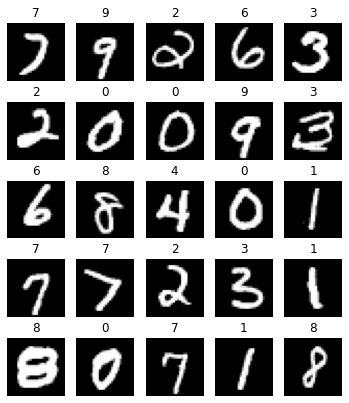

In [25]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [7]:
class Net(nn.Module):
    
    def __init__(self, activation=nn.Tanh(), initialization=None):
        super(Net, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 500),
                                           activation,
                                           nn.Linear(500, 10),
                                           nn.LogSoftmax(dim=1)) 
        
        for i in range(0, len(self.linear_layers), 2):
            
            shape = self.linear_layers[i].state_dict()['weight'].shape
            
            if initialization is not None:
                mean, std = initialization(shape[1], shape[0])
            else:
                mean, std = 0, 0.1
                
            self.linear_layers[i].register_forward_hook(forward_hook)
            self.linear_layers[i].register_backward_hook(backward_hook)
            
            init_layer(self.linear_layers[i], mean, std)
            
        
    def forward(self, x):
        
        x = x.view(x.shape[0], -1)
        x = self.linear_layers(x)
        
        return x

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
network = Net()

In [9]:
def nn_launch(network, train_loader):
    X, y = next(iter(train_loader))

    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

    print("Activation std")
    activations = network(X)

    loss = loss_fn(activations, y)
    print("\nGradient std")
    loss.backward()

In [10]:
nn_launch(network, train_loader)

Activation std
forward 0.9979166984558105
forward 0.846793532371521
forward 0.7873834371566772
forward 0.7712650895118713
forward 0.7656145691871643
forward 0.7654758095741272
forward 0.7642500996589661
forward 0.7664723992347717
forward 0.7667000889778137
forward 0.7650085687637329
forward 0.7647863030433655

Gradient std
backward 0.043555110692977905
backward 0.006587563082575798
backward 0.007374009117484093
backward 0.008999376557767391
backward 0.01051436085253954
backward 0.01169375516474247
backward 0.013667124323546886
backward 0.01688845083117485
backward 0.019895054399967194
backward 0.02292531542479992
backward 0.0232714731246233


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [11]:
def Xavier(input_size, output_size):
    
    return 0, np.sqrt(2/(input_size + output_size))

In [12]:
def He(input_size, output_size):
    
    return 0, np.sqrt(2/(output_size))

In [13]:
network = Net(initialization=Xavier)

In [14]:
nn_launch(network, train_loader)

Activation std
forward 0.9835147261619568
forward 0.6423864960670471
forward 0.4898730218410492
forward 0.4093818962574005
forward 0.3565155863761902
forward 0.3197169303894043
forward 0.2929767370223999
forward 0.2720728814601898
forward 0.2541361153125763
forward 0.23709988594055176
forward 0.2263253778219223

Gradient std
backward 0.01861327514052391
backward 0.003208294976502657
backward 0.003050935221835971
backward 0.003053364809602499
backward 0.002854334656149149
backward 0.0027022543363273144
backward 0.0025988505221903324
backward 0.0024168770760297775
backward 0.002129644388332963
backward 0.0019581930246204138
backward 0.0016866602236405015


In [15]:
network = Net(activation=nn.ReLU(), initialization=He)

In [19]:
nn_launch(network, train_loader)

Activation std
forward 1.0141891241073608
forward 1.0415130853652954
forward 1.0423036813735962
forward 1.018734097480774
forward 1.0742220878601074
forward 1.0743213891983032
forward 1.0554677248001099
forward 1.1028867959976196
forward 1.0700139999389648
forward 1.0271517038345337
forward 1.0384830236434937

Gradient std
backward 0.17121413350105286
backward 0.15385006368160248
backward 0.14907601475715637
backward 0.1350288838148117
backward 0.12153009325265884
backward 0.10892529785633087
backward 0.10425669699907303
backward 0.0890578031539917
backward 0.08231677860021591
backward 0.08444181084632874
backward 0.0729619562625885


<i> 1.4 Сделайте выводы по первой части </i>

Проанализировав полученные результаты можно сделать вывод, что все три инициализации дают относительно небольшие и при этом мало отличающиеся между слоями дисперсии и для функции активации, и для градиента. 

Наилучшие результаты достигаются на инициализации Xavier.

 Так же можно заметить что что инициализация He отдает больший приорит уменьшению дисперсии градиента, чем активации, ведь мы делим в формуле на количество выходных каналов а не входных, что способствовало бы уменьшению дисперсии активации

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [8]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):   
        
        mask = torch.zeros(self.linear.weight.shape, requires_grad=False)
        
        if self.training:
            mask = mask.bernoulli_(self.p)
        else:
            mask += self.p

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

In [21]:
torch.zeros((2, 3), requires_grad=False).bernoulli_(0.5)

tensor([[0., 0., 0.],
        [1., 0., 0.]])

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [26]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [3]:
layers = [nn.Linear(196, 128),
         nn.ReLU(),
         nn.Dropout(0.5),
         nn.Linear(128, 128),
         nn.ReLU(),
         nn.Dropout(0.5),
         nn.Linear(128, 128),
         nn.Softmax()
         ]

Epoch 9... (Train/Test) NLL: 0.021/0.055	Accuracy: 0.993/0.983


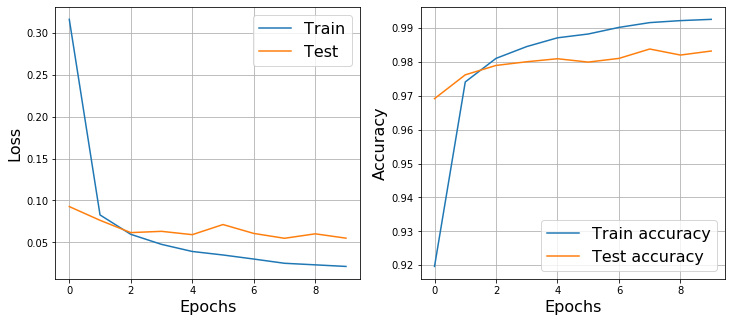

In [33]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001);# device='cuda')

In [9]:
layers = [
    DropConnect(196, 128, p=0.5),
    nn.ReLU(),
    DropConnect(128, 128, p=0.5),
    nn.ReLU(),
    DropConnect(128, 10, p=0.5)
]

Epoch 9... (Train/Test) NLL: 0.163/0.089	Accuracy: 0.949/0.971


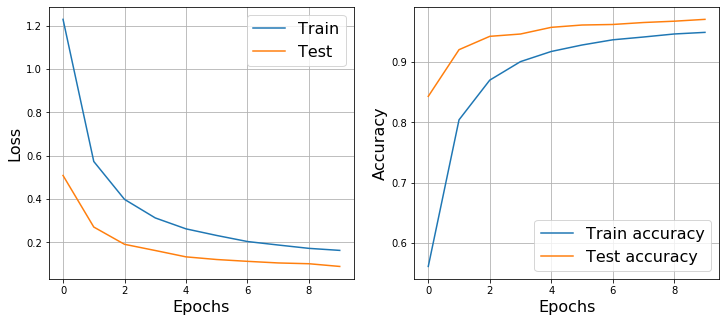

In [35]:
network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001);# device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Как и ожидалось применение обоих типов Dropout слоев заметно уменьшает переобучение и точность на тесте превосходит точность на трейне. При использовании DropConnect эффект проявляется сильнее 

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [35]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    
    
    def __init__(self, eps=1e-6):
        super().__init__() 
        self.eps = eps
    
    
    def forward(self, x):
#         print(x, x.std(0))
#         if x.std(0) != 0:
        output = (x - x.mean(0)) / ((x.std(0) + self.eps)**2)
#         else:
#             output = (x - x.mean(0)) / self.eps
            
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.022/0.053	Accuracy: 0.993/0.983


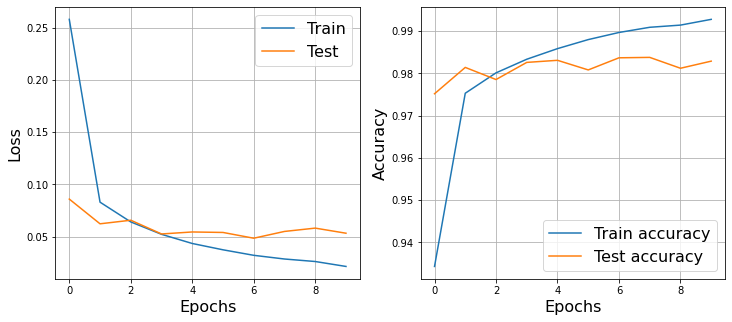

In [28]:
layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128, affine=False),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128, affine=False),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001);

Epoch 9... (Train/Test) NLL: 0.024/0.064	Accuracy: 0.991/0.981


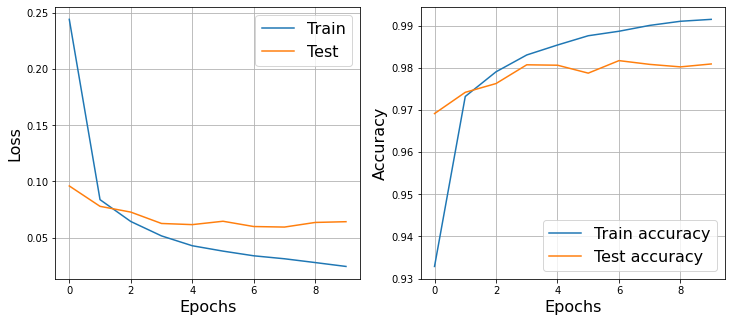

In [36]:
layers = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001);

<i> 3.3 Сделайте выводы по третьей части </i>

По графикам обучения нейронных сетей можно заметить что при применении батч-нормализации сети сходятся быстрее и уже на первой эпохе loss падает до 0.1, в то время как без батч-нормализации loss на первой эпохе в районе 0.5. При применении LayerNormalization результаты схожие.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: